In [57]:
import pandas as pd
import numpy as np
import itertools
import sklearn

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

import missingno as msno

import matplotlib.pyplot as plt

import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

# Machine Learning for Diabetes Prediction

This project aims to use machine learning techniques to predict the likelihood of developing diabetes based on various health and lifestyle indices. The data used in this project is a dataset of health and lifestyle indicators, including factors such as age, BMI, physical activity, and alcohol consumption. By training and testing various machine learning models on this data, we hope to gain insights into which factors play the biggest role in determining the risk of developing diabetes, and to build a model that accurately predicts the likelihood of the disease based on these indicators.

In [2]:
#loading the dataset from CSV 
data = pd.read_csv('diabetes_health_indicators_BRFSS2015.csv')

#dropping the duplicated rows in the CSV
data.drop_duplicates(inplace = True)       

# The Dataset

First, let's take a closer look at the data. There are 3 columns of categorical data, one of which is the target column indicating the presence of diabetes. 
The remaining columns are composed of numerical data, all of which are binary except for the 'age', 'BMI', and the columns that contains the self-evaluation of the mental and physical health.

In [3]:
data.head()
data.info()
data.describe(include='all') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236756 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       236756 non-null  object 
 1   HighBP                236756 non-null  float64
 2   HighChol              236756 non-null  float64
 3   CholCheck             194916 non-null  float64
 4   BMI                   236739 non-null  float64
 5   Smoker                236680 non-null  float64
 6   Stroke                236756 non-null  float64
 7   HeartDiseaseorAttack  236756 non-null  float64
 8   PhysActivity          236706 non-null  float64
 9   Fruits                236756 non-null  float64
 10  Veggies               236756 non-null  float64
 11  HvyAlcoholConsump     236756 non-null  float64
 12  AnyHealthcare         206997 non-null  float64
 13  NoDocbcCost           236122 non-null  float64
 14  GenHlth               236756 non-null  object 
 15  

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,236756,236756.000000,236756.000000,194916.000000,236739.000000,236680.000000,236756.000000,236756.000000,236706.000000,236756.000000,...,206997.000000,236122.000000,236756,236604.000000,236756.000000,236756.000000,236675,236756.000000,235744.000000,235491.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5,NaN,NaN,NaN,2,NaN,NaN,NaN
top,Non-Diabetic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,very good,NaN,NaN,NaN,female,NaN,NaN,NaN
freq,201546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81061,NaN,NaN,NaN,132579,NaN,NaN,NaN
mean,NaN,0.447663,0.437193,0.960244,28.599715,0.459916,0.043441,0.100449,0.740383,0.618620,...,0.947048,0.090161,NaN,3.406925,4.540721,0.180143,NaN,8.074144,4.999733,5.937463
std,NaN,0.497254,0.496041,0.195385,6.730361,0.498392,0.203849,0.300599,0.438426,0.485727,...,0.223939,0.286413,NaN,7.622976,8.947373,0.384308,NaN,3.084325,0.990585,2.086061
min,NaN,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000
25%,NaN,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,6.000000,4.000000,5.000000
50%,NaN,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,8.000000,5.000000,6.000000
75%,NaN,1.000000,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,NaN,2.000000,3.000000,0.000000,NaN,10.000000,6.000000,8.000000


In [4]:
#checking unique values in all the columns
unique_values = {}
for col in data.columns:
    unique_values[col] = data[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
Diabetes_binary,2
HighBP,2
HighChol,2
CholCheck,2
BMI,84
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


## Intra-Data Relations
let's start the analysis of the data and find the correlation that can be seen even by a human eye.

array([[<AxesSubplot:title={'center':'HighBP'}>,
        <AxesSubplot:title={'center':'HighChol'}>,
        <AxesSubplot:title={'center':'CholCheck'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'Smoker'}>,
        <AxesSubplot:title={'center':'Stroke'}>,
        <AxesSubplot:title={'center':'HeartDiseaseorAttack'}>,
        <AxesSubplot:title={'center':'PhysActivity'}>],
       [<AxesSubplot:title={'center':'Fruits'}>,
        <AxesSubplot:title={'center':'Veggies'}>,
        <AxesSubplot:title={'center':'HvyAlcoholConsump'}>,
        <AxesSubplot:title={'center':'AnyHealthcare'}>],
       [<AxesSubplot:title={'center':'NoDocbcCost'}>,
        <AxesSubplot:title={'center':'MentHlth'}>,
        <AxesSubplot:title={'center':'PhysHlth'}>,
        <AxesSubplot:title={'center':'DiffWalk'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Education'}>,
        <AxesSubplot:title={'center':'Income'}>, <AxesSubplot:

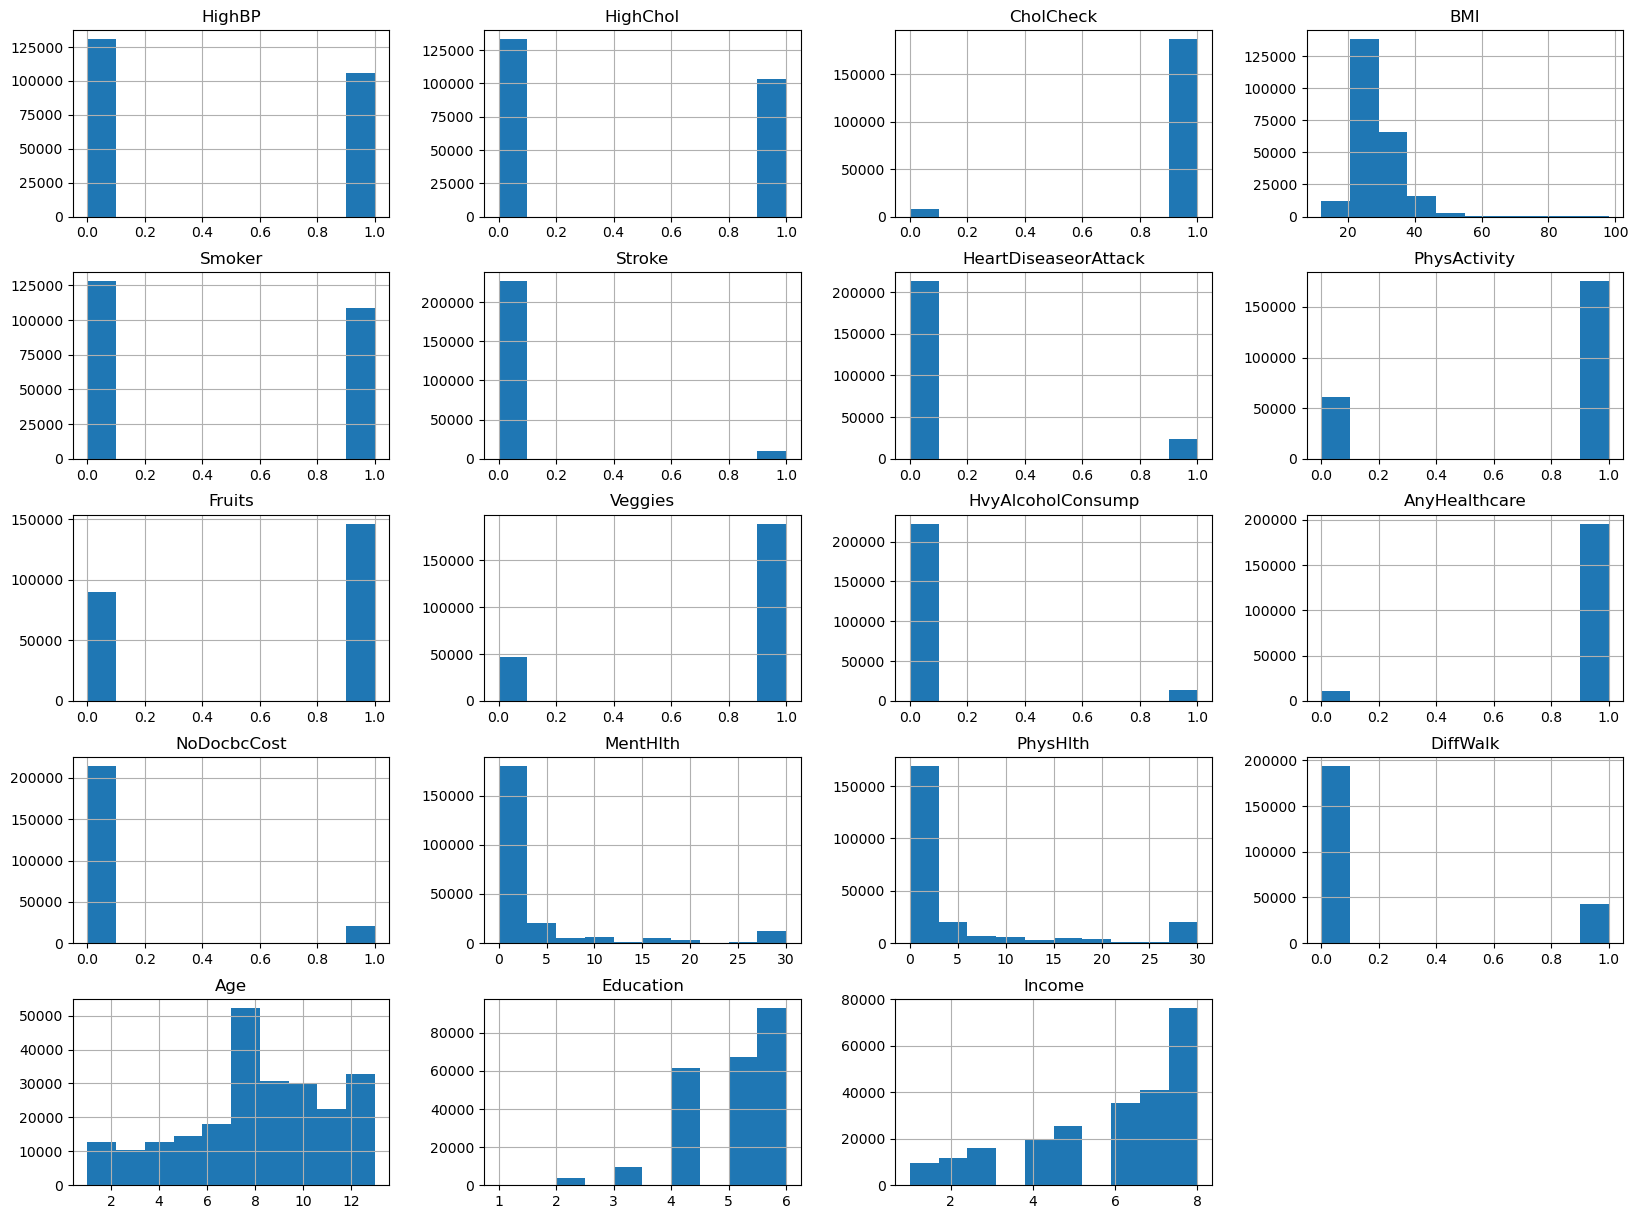

In [5]:
#creating histograms
data.hist(figsize=(20,15))

with these histograms, we can see how the data our distributed and wich of the classes are unbalanced

## The study of the target
In this section i will focus on the target column to better understend how is composed and its correlation with some of the other classes

In [6]:
#countig the entries for every unique value in the target
data["Diabetes_binary"].value_counts()

Non-Diabetic    201546
Diabetic         35210
Name: Diabetes_binary, dtype: int64

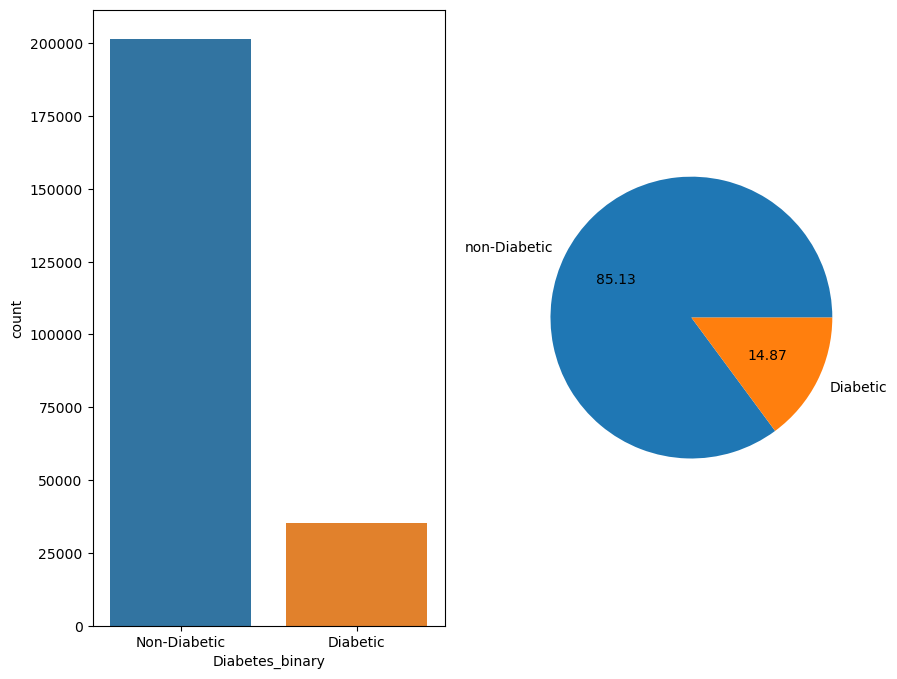

In [7]:
#displaying the distribution of the target column
figure1, plot1 = plt.subplots(1,2,figsize=(10,8))
sns.countplot(data['Diabetes_binary'],ax=plot1[0])
labels=["non-Diabetic","Diabetic"]
plt.pie(data["Diabetes_binary"].value_counts() , labels =labels ,autopct='%.02f' );

With this visualization is clear that there is a huge unbalance in the target class but it will not be a problem thanks to the large amount of data in our dataset, this will be one of the first things to solve.

In [8]:
#mapping the value of type string in the target class to 0 and 1
data["Diabetes_binary"]= data["Diabetes_binary"].replace({"Non-Diabetic":0,"Diabetic":1})

We can easly map the two values that represent the presence or the absence of the diabet into the much more handable 0 and 1 value

### Underlying correlations between the target and some features

Text(0.5, 1.0, 'correlation of feature')

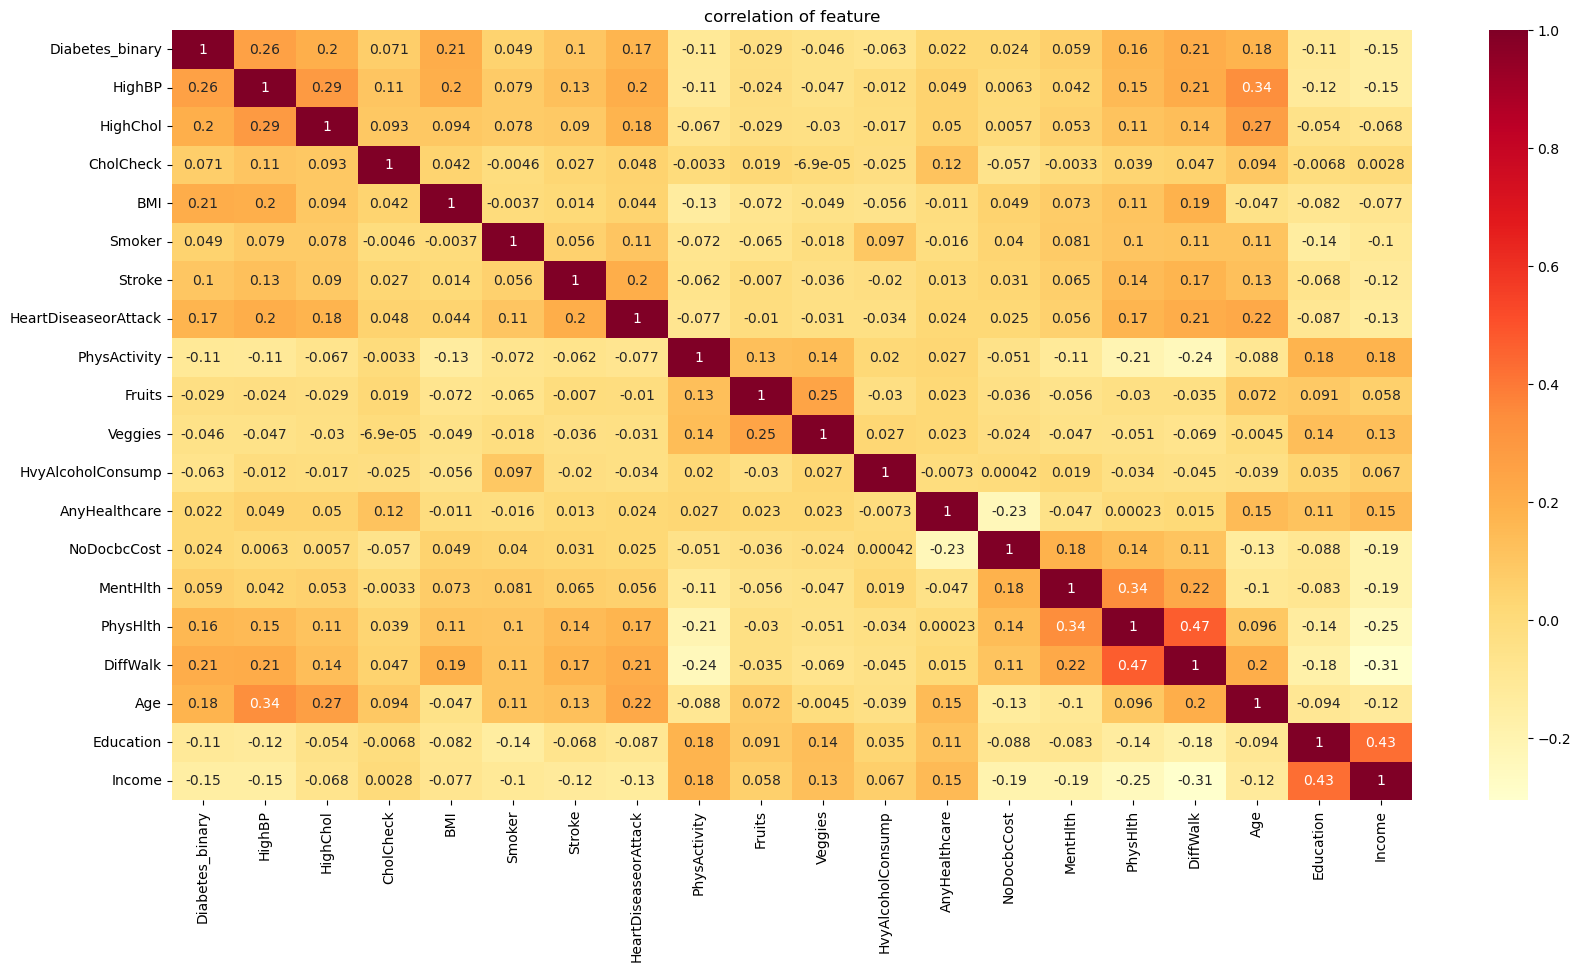

In [9]:
#using heatmap to understand correlation better in dataset data 
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(),annot=True , cmap ='YlOrRd' )
plt.title("correlation of feature")

Through this heatmap, we can start to see some correspondence between the target and some features such as highcol and BMI, but even correspondences between different features such as the tautological physhlth-diffwalk or the less obvious education-income.

#### The correspondence with the feature "age"

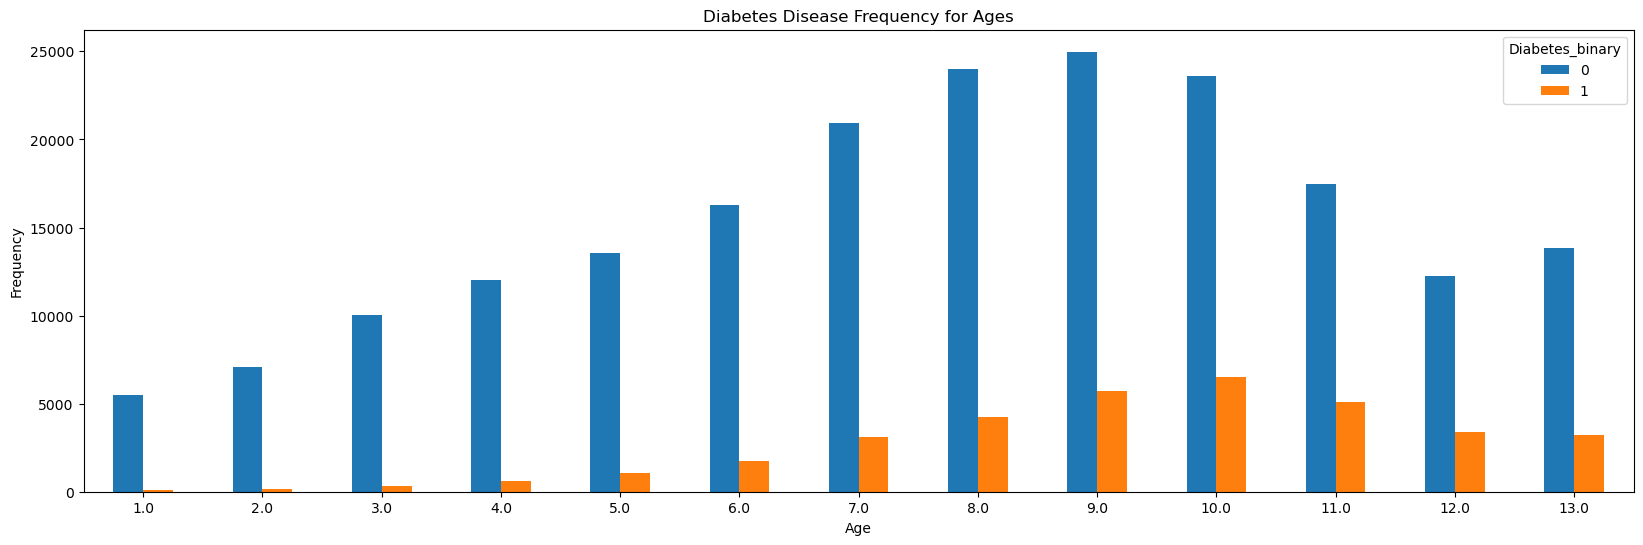

In [10]:
#plotting the feature "Age" and it's relation with the target
pd.crosstab(data.Age,data.Diabetes_binary).plot(kind="bar",figsize=(20,6))
plt.title('Diabetes Disease Frequency for Ages')
plt.xlabel('Age')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

As we could imagine from general knowledge, the diabetes disease frequency increase at higher ages. From above we can say that the median of the age of diabetic people is greater than that of non-diabetic people.

#### The correspondence with the feature "Income"

Text(0.5, 1.0, 'Relation b/w Income and Diabetes')

<Figure size 2000x1000 with 0 Axes>

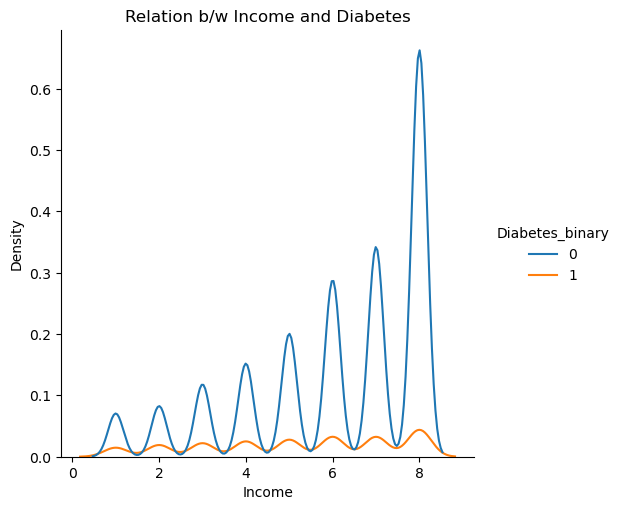

In [11]:
#plotting the feature "Income" and it's relation with the target
plt.figure(figsize=(20,10))
sns.displot(data=data, x="Income", hue="Diabetes_binary", kind="kde")
plt.title("Relation b/w Income and Diabetes")

This plot shows how much the diabete is less frequent when a person has a higher income, this is particularly significant as it trace a link between social aspects of life and this illness. Some speculation about this can be:

.Higher income individuals may have access to healthier food options and resources for exercise, leading to a lower incidence of diabetes.

.Higher income individuals may have a more sedentary lifestyle and job, leading to a higher incidence of diabetes.

.There may be a correlation between low education levels and low income, leading to a lack of knowledge about healthy lifestyle choices and an increased incidence of diabetes.

.Higher income individuals may have better access to healthcare, early detection, and management of diabetes.

.There may be a correlation between stress levels and income, with higher stress levels in high income individuals leading to an increased incidence of diabetes.

#### The correspondence with the features "HighBP" and "HighChol"

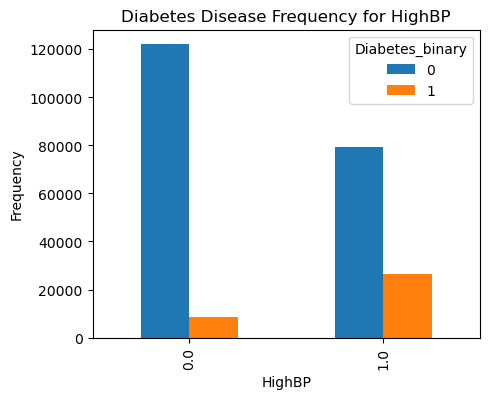

In [12]:
#Checking The relation B/W HighBP and Diabetes

pd.crosstab(data.HighBP,data.Diabetes_binary).plot(kind="bar",figsize=(5,4))

plt.title('Diabetes Disease Frequency for HighBP')
plt.xlabel("HighBP")
plt.ylabel('Frequency')
plt.show()

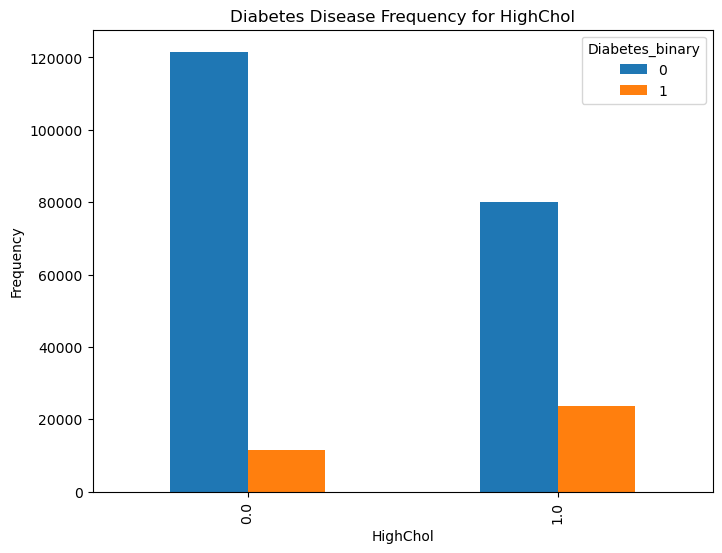

In [13]:
#Checking The relation B/W HighChol and Diabetes

pd.crosstab(data.HighChol,data.Diabetes_binary).plot(kind="bar",figsize=(8,6))

plt.title('Diabetes Disease Frequency for HighChol')
plt.xlabel("HighChol")
plt.ylabel('Frequency')
plt.show()

There is a positive correlation between high blood pressure and the occurrence of diabetes. Individuals with high blood pressure are more likely to develop diabetes due to the strain on their cardiovascular system.
There is a positive correlation between high cholesterol levels and the occurrence of diabetes. High cholesterol levels increase the risk of cardiovascular disease, which is a common complication of diabetes.
Individuals with both high blood pressure and high cholesterol levels are at a higher risk of developing diabetes. We can imagine that the combination of these two health factors increases the strain on the cardiovascular system, making it more likely for diabetes to develop but the relationship between high blood pressure, high cholesterol levels, and diabetes may be complex and influenced by other factors such as age, lifestyle, and genetics.

#### The correspondence with the features "DiffWalk"

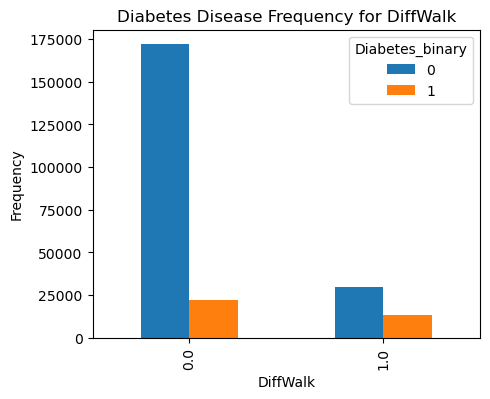

In [14]:
#Checking The relation B/W DiffWalk and Diabetes

pd.crosstab(data.DiffWalk,data.Diabetes_binary).plot(kind="bar",figsize=(5,4))

plt.title('Diabetes Disease Frequency for DiffWalk')
plt.xlabel("DiffWalk")
plt.ylabel('Frequency')
plt.show()

There is a positive relation between this two conditions even if the difficulty in walking can be caused by a huge number of factors but individuals with difficulty in walking may have underlying health conditions that increase their likelihood of developing diabetes.
A sedentary lifestyle resulting from difficulty in walking may lead to a higher risk of developing diabetes. 

## Feature Selection
It involves choosing the most relevant features, the features that have the highest impact on the target variable, and leaving out the irrelevant ones. This process helps in reducing the complexity of the model, increasing its interpretability and improving its performance. In the next section, we will use various techniques such as correlation analysis to select the most important features in the dataset.

### Missing value in the features
The missingno matrix helps us in visualizing the feature with a lot of missing values.

<AxesSubplot:>

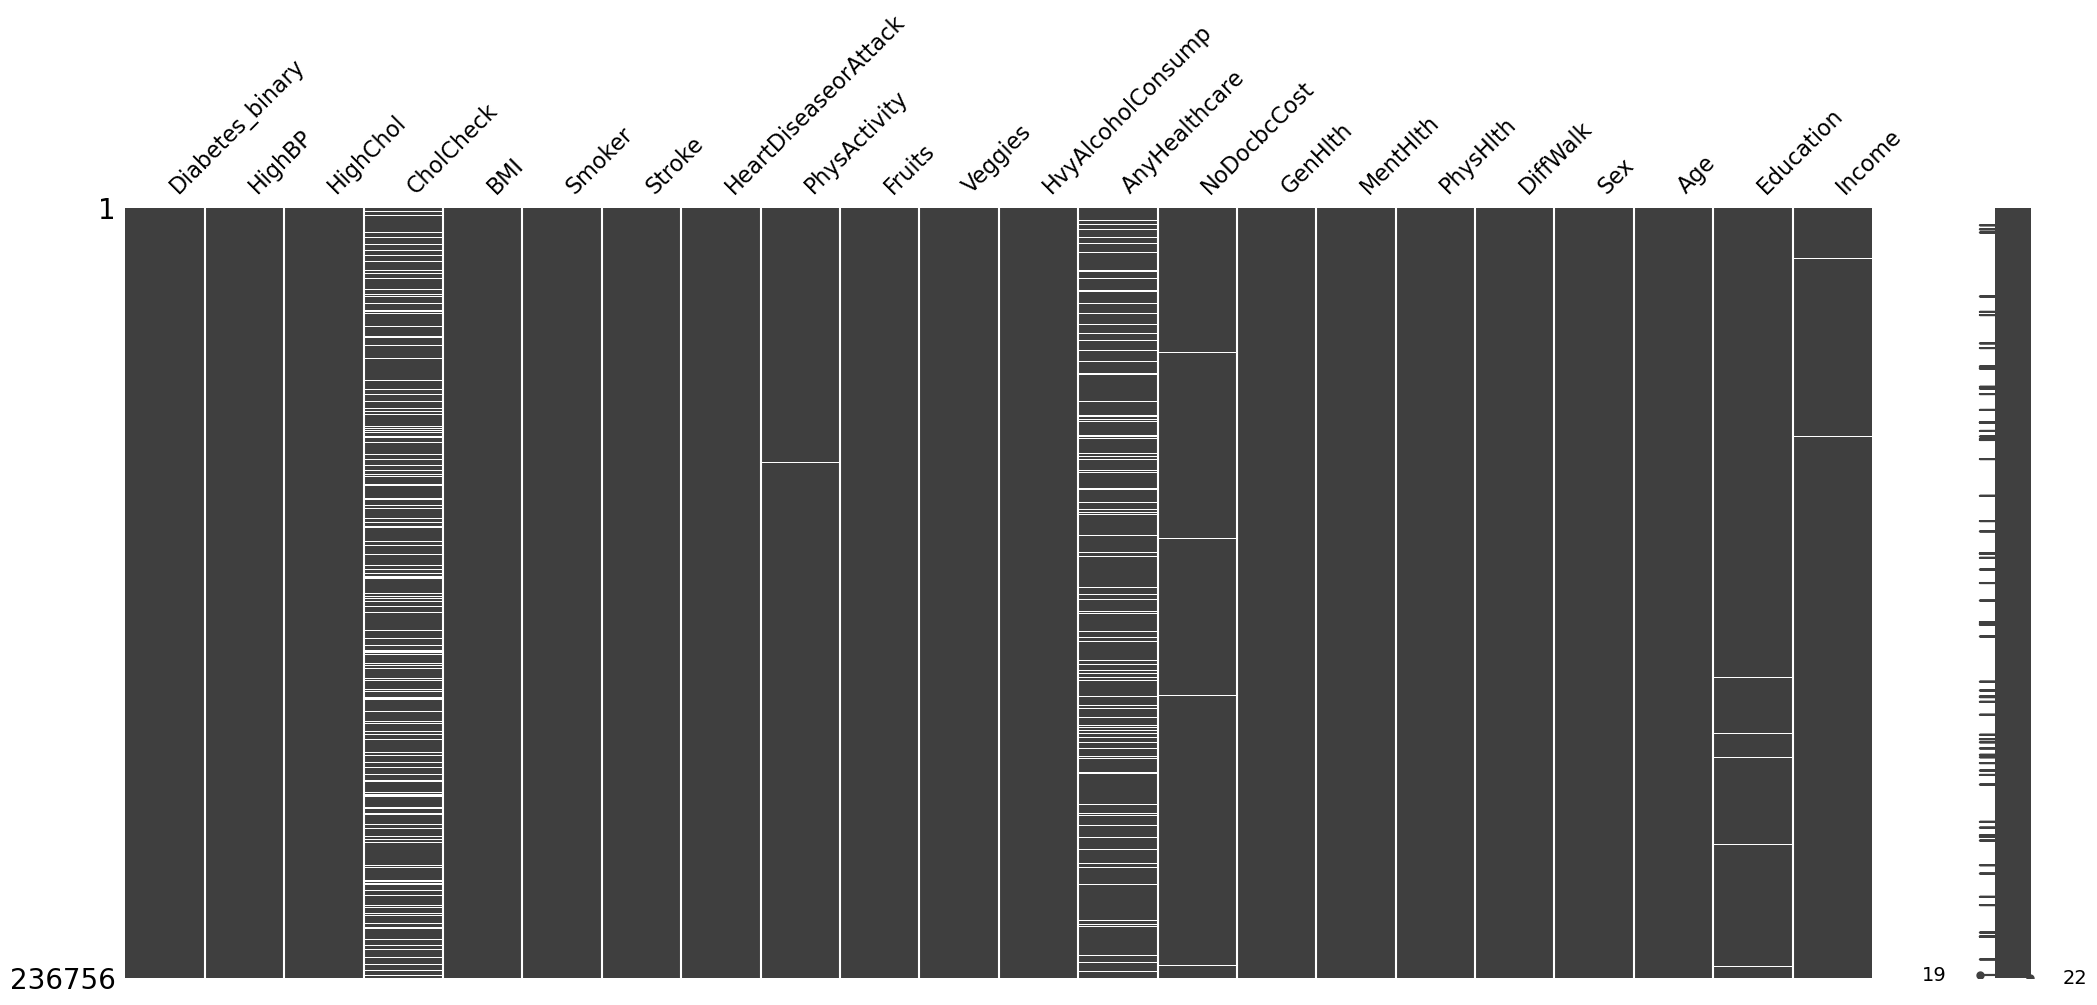

In [15]:
msno.matrix(data)

### Feature corrispondece with the target

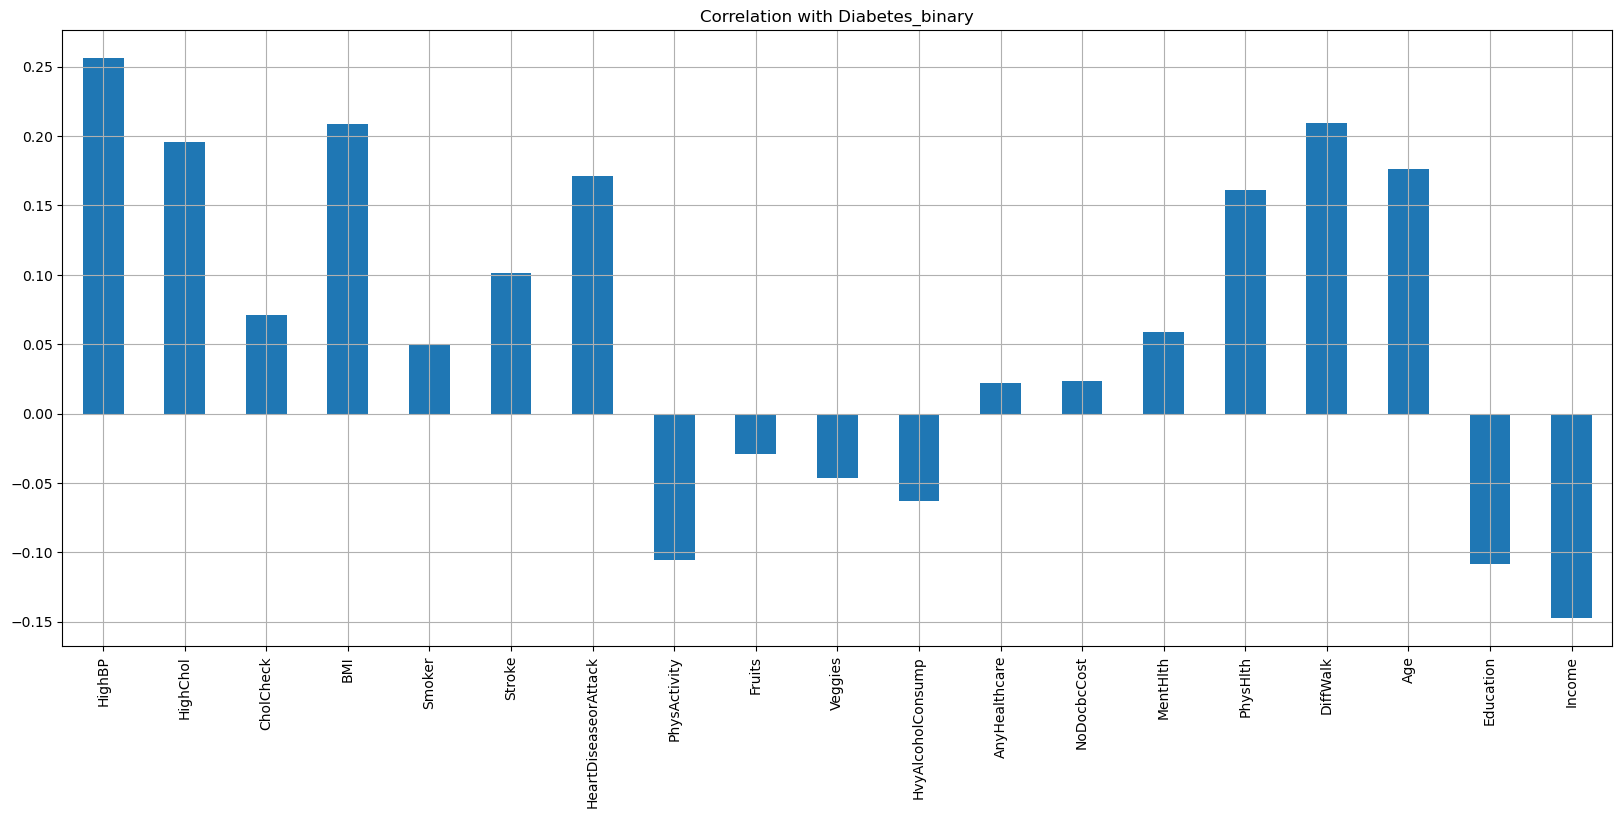

In [16]:
#plotting the corrispondece with the target
data.drop('Diabetes_binary', axis=1).corrwith(data.Diabetes_binary).plot(kind='bar', grid=True, figsize=(20, 8)
, title="Correlation with Diabetes_binary");

By cross-referencing the results of this graph with the results of the heatmap and the missgno matrix, we can notice that the features 'cholcheck' and 'anyhealthcare' do not have a correlation with the target and have several missing values, so I have decided to deselect them.

In [17]:
#dropping irrelevant columns from the dataframe
colomns = ["CholCheck" , "AnyHealthcare"]
data.drop(colomns , axis= 1 ,inplace=True)

### Others feature modifications

In [18]:
#checking for other missing values while separating the target from the feature

In [19]:
y = data.pop('Diabetes_binary')
X = data

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236756 entries, 0 to 253679
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                236756 non-null  float64
 1   HighChol              236756 non-null  float64
 2   BMI                   236739 non-null  float64
 3   Smoker                236680 non-null  float64
 4   Stroke                236756 non-null  float64
 5   HeartDiseaseorAttack  236756 non-null  float64
 6   PhysActivity          236706 non-null  float64
 7   Fruits                236756 non-null  float64
 8   Veggies               236756 non-null  float64
 9   HvyAlcoholConsump     236756 non-null  float64
 10  NoDocbcCost           236122 non-null  float64
 11  GenHlth               236756 non-null  object 
 12  MentHlth              236604 non-null  float64
 13  PhysHlth              236756 non-null  float64
 14  DiffWalk              236756 non-null  float64
 15  

Now we can map our cathegorical data to make them numerical

In [20]:
#mapping for cathegorical data
X["GenHlth"]= X["GenHlth"].replace({"excellent":5,"very good":4,"good":3,"fair":2,"poor":1})

X["Sex"]= X["Sex"].replace({"female":0,"male":1})

X.describe()


,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,236756.000000,236756.000000,236739.000000,236680.000000,236756.000000,236756.000000,236706.000000,236756.000000,236756.000000,236756.000000,236122.000000,236756.000000,236604.000000,236756.000000,236756.000000,236675.000000,236756.000000,235744.000000,235491.000000
mean,0.447663,0.437193,28.599715,0.459916,0.043441,0.100449,0.740383,0.618620,0.799769,0.059411,0.090161,3.424644,3.406925,4.540721,0.180143,0.439827,8.074144,4.999733,5.937463
std,0.497254,0.496041,6.730361,0.498392,0.203849,0.300599,0.438426,0.485727,0.400174,0.236394,0.286413,1.065224,7.622976,8.947373,0.384308,0.496367,3.084325,0.990585,2.086061
min,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,6.000000
75%,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


### Creating the pipeline
The use of a pipeline in this model serves to streamline the machine learning process. A pipeline allows for the combination and automation of multiple steps in the modeling process, such as feature scaling and imputing.

In [21]:
#pipeline numirical
pipeline_numerical = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent') ),
    ('scaler', StandardScaler() )
])

### Creating the column trasformer
With this column trasformer the pipeline can be applied to the columns

In [22]:
#setting the column transformer
final_transformation = ColumnTransformer(transformers=[
    ('SexS', pipeline_numerical ,['Sex','GenHlth','Age','BMI','MentHlth','HighBP','HighChol','Smoker','Stroke','HeartDiseaseorAttack','PhysActivity','Fruits','Veggies','HvyAlcoholConsump','NoDocbcCost','DiffWalk','PhysHlth','Income','Education'] )
],
    
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

In [23]:
# fitting the column transformer and run it to modify X
final_transformation.fit(X)
X_transformed = final_transformation.transform(X)

Now i have applied the column transformer to fill all the missing value and being able to solve the problem of the asimmetricity of the target column that i have underlined at the start of the project

### Splitting the data in train and test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=30, shuffle=True, stratify=y )

Here the first raw model can be set up in a pipeline.

In [26]:
#setting the raw model
model_pipeline = IMBPipeline([
    ('sampler', RandomUnderSampler()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [27]:
#fitting the raw model
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [28]:
#predicting with the raw model
model_pipeline.predict(X_test)

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

## Cross-validation to find an optimal model

#### Creating the list of possible configurations
Here are listed the possible setting for the parameters of the dimensionality reduction and in particular of the model. 

In [37]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LinearDiscriminantAnalysis()]
    }
]

sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[NearMiss(version = 1 , n_neighbors = 10)],
    }
]

classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },

    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100,500]
    },
    {
        'classifier': [XGBClassifier()],
        'classifier__learning_rate': loguniform(0.001, 1),
        'classifier__n_estimators': [10, 100, 500],
        'classifier__max_depth': [3, 5, 7]
    }
]

In [38]:
#creating the dictionaries for all the configurations 
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(classifier_configs,dim_reduction_configs,sampler_configs)]

In [39]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 27'

The cross-validation will be composed by an internal randomized search and from the outer cross-validation both using the score f1 to evaluate the model

In [49]:
#setting up the internal randomized search
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

In [50]:
#setting up the outer cross-validation
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3) #14min

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.458 total time=37.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 37.8min remaining:    0.0s


[CV] END ......................................., score=0.459 total time=28.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 66.5min remaining:    0.0s


[CV] END ......................................., score=0.456 total time=48.0min
[CV] END ......................................., score=0.459 total time=27.9min
[CV] END ......................................., score=0.454 total time=39.7min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 182.1min finished


In [51]:
#getting the best model for every fold and their parameters
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, sampling_strategy=0.7)
LinearDiscriminantAnalysis()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0073523375082168866,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': No

In [79]:
#getting the f1 score on both train and test set 
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    print(f'accuracy on training set:{accuracy_train}, accuracy on test set:{accuracy_test}')
    print('-'*30)
    recall_train = recall_score(y_train, pred_train)
    recall_test = recall_score(y_test, pred_test)
    print(f'recall on training set:{recall_train}, recall on test set:{recall_test}')
    print('-'*30)
    precision_train = precision_score(y_train, pred_train)
    precision_test = precision_score(y_test, pred_test)
    print(f'precision on training set:{precision_train}, precision on test set:{precision_test}')
    print('=='*30)

accuracy on training set:0.7597946044446053, accuracy on test set:0.7603446576653948
------------------------------
recall on training set:0.6803262060291313, recall on test set:0.6814351983338067
------------------------------
precision on training set:0.344326255698386, precision on test set:0.34514504914888516
accuracy on training set:0.7724115875917914, accuracy on test set:0.7734945865656722
------------------------------
recall on training set:0.6465695622185256, recall on test set:0.6518981349995266
------------------------------
precision on training set:0.3545824711300981, precision on test set:0.3568430325957403
accuracy on training set:0.7739683459141128, accuracy on test set:0.7745364438875357
------------------------------
recall on training set:0.6443786262019718, recall on test set:0.6468806210356907
------------------------------
precision on training set:0.3562823877784508, precision on test set:0.35743055918815714
accuracy on training set:0.758237846122284, accuracy o

## The optimal model
In order to choose the optimal model we can pick the one with the higher f1 score on the test set (=unseen data) and re-run a optimamized random search on its parameters.

In [58]:
#setting up the pipeline for the optimal model
best_model_pipeline = IMBPipeline([
    ('dim_reduction', LinearDiscriminantAnalysis()),
    ('sampler', SMOTE(n_jobs=-1, sampling_strategy=0.7)),
    ('classifier', XGBClassifier(max_depth = 3))
])

In [59]:
#setting up the parameters with optimized distribution
params = {
    'classifier__learning_rate': uniform(loc = 0.001, scale = 1),
    'classifier__n_estimators': [10, 50, 100, 200, 500]
    
}

In [60]:
#setting up the final randomized search
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=5,
    scoring='recall'
)

#### The choice of recall
In the last randomize search i choose recall as a metrics to minimize the false negative results and still be sure to have a stable model.

In [61]:
#fitting the rs
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('dim_reduction',
                                              LinearDiscriminantAnalysis()),
                                             ('sampler',
                                              SMOTE(n_jobs=-1,
                                                    sampling_strategy=0.7)),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None...
                                 

In [62]:
#returnig the best model
rs_best.best_estimator_

Pipeline(steps=[('dim_reduction', LinearDiscriminantAnalysis()),
                ('sampler', SMOTE(n_jobs=-1, sampling_strategy=0.7)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=Non...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.44622581309257303, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,

## Prediction results

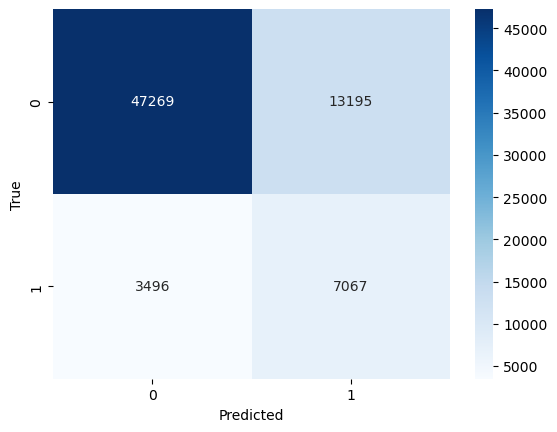

In [67]:
y_pred = rs_best.predict(X_test)
cm =  confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Evaluating the optimal model

### Parameters

In [80]:
#setting variables for plotting
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

(0.2, 0.8)

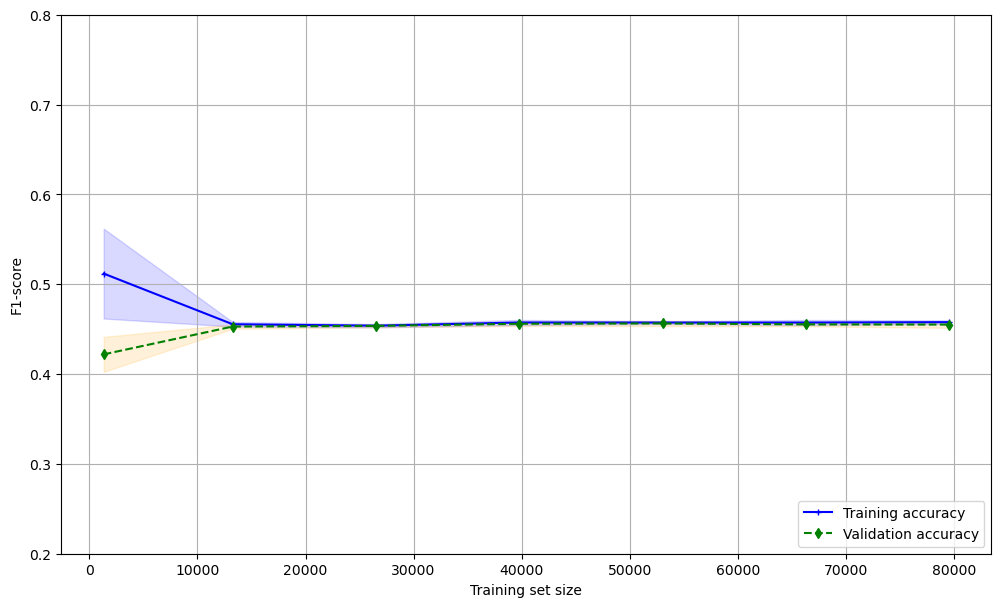

In [81]:
#plotting the learning curve
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='orange')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.2, 0.8])

(25.0, 1000.0)

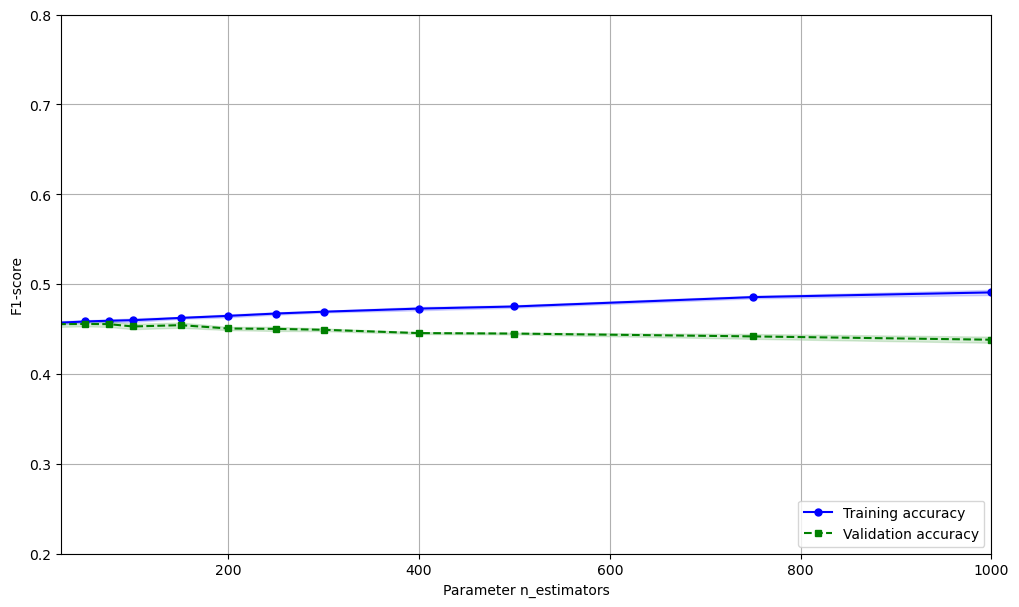

In [75]:
range_n_estimators = [10,50,75,100,150,200,250,300,400,500,750,1000]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=range_n_estimators, 
        param_name='classifier__n_estimators',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_n_estimators, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_n_estimators,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_n_estimators, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_n_estimators,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter n_estimators')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.2, 0.8])
ax.set_xlim([25,1000])

### Metrics

#### The ROC curve
 It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different threshold settings. The TPR represents the proportion of positive cases that were correctly identified, while the FPR represents the proportion of negative cases that were incorrectly classified as positive. The ROC curve is useful because it provides a visual summary of the trade-off between the TPR and the FPR for different threshold settings, enabling the evaluation of the classifier's overall performance in a single plot. The area under the ROC curve (AUC) is often used as a summary measure of the classifier's performance.

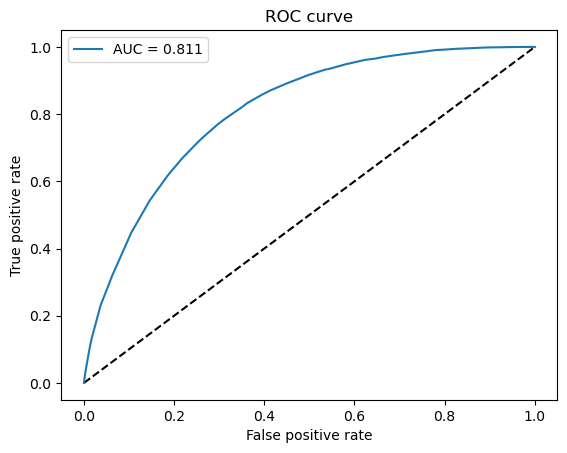

In [76]:
y_pred_prob = rs_best.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Reasoning about the performance scores

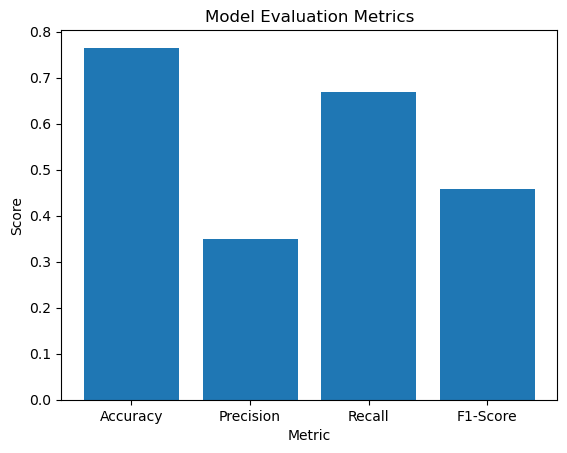

In [83]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = [acc, prec, rec, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.bar(labels, metrics)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dbed758e-5e52-4ed3-af2d-be3d78db3ce7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>